# 한국어 수화 해석하는 서비스 만들기 



# 필요한 라이브러리 설치 및 import 
1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import time
import mediapipe as mp
import cv2
import os

In [ ]:
#GPU를 사용하는 tensorflow와 mediapipe 설치 

#mediapipe란 ? 주로 멀티 모달 오디오, 비디오 또는 모든 시계열 데이터를 구축하는 데 사용되는 프레임 워크입니다.

#using tensorflow with GPU, mediapipe detacting movements
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

# MP Holistic을 사용하여 pose, face, righthand, lefthand에 대한 <br>key point 생성하기 
2. Keypoints using MP Holistic


In [2]:
mp_holistic = mp.solutions.holistic 
#mp.solutions.holistic 이란 ? -> 실시간 모션인식 (얼굴,몸의 분절을 실시간으로 추적한다.)

#Live perception of simultaneous human pose, face landmarks, 
#and hand tracking in real-time on mobile devices can enable various modern life applications
#https://google.github.io/mediapipe/solutions/holistic.html



mp_drawing = mp.solutions.drawing_utils # Drawing utilities
# 점을 연결하여 선을 보여준다.

In [3]:
# 이미지를 추적하는 함수 만들기 
#이미지 -> RGB형식으로 만들어 모델에 대입한 결과를 results에 담고, 원상태로 만든 이미지와 results를 출력한다. 

def mediapipe_detection(image, model):   # 대상을 추적한다. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction 모델에 대입 
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
# 동영상에 점 찍기 

def draw_landmarks(image, results):  # 동영상의 frame과 동영상에서 받은 result를 받는다. 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # 얼굴의 점을 연결하여 그린다.
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # POSE를 연결햐여 그린다.
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # 왼손 그리기
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # 오른손 그리기 

In [5]:
# 더 정확한 판단을 위해 각각의 노드에 두개의 점을 추가한다. 
#add aditional 2 spots to the image

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Keypoint 값을 넘파이 형태로 추출하기 
3. Extract Keypoint Values

results.pose_landmarks.landmark -> [res.x, res.y, res.z, res.visibility]으로 구성 <br>
그외는 <br>
results.face_landmarks.landmark -> [res.x, res.y, res.z]으로 구성 


In [6]:
## 위에서 만든 코드를 함수로 만들기 

# pose, face, lh, rh의 순서로 저장한다. 
# np.concatenate 를 하여 넘파이 배열을 하나로 합친다. 

###위의 코드를 간단하게 하고 pose, face, lh,rh로 된 각각의  numpy 배열로 만들기 
# 넘파이배열 -> flatten 하기 
# 입력된 값이 없다면 0으로 채우기 (x,y,z 세개만큼, x3해준다.)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

#extract_keypoints(results).shape 
# (1662,) -> 468*3 + 33*4 + 21*3 + 21*3 


# 데이터 축적하기 
4. Setup Folders for Collection


In [12]:
actions = np.array(['고치다','멈추다','춥다','고혈압', '저혈압','수술' ,'피곤하다','x-ray사진','충격','약'])##리스트 안에 해석할 단어를 적는다

In [ ]:
#폴더 만들기 
#make a folder
import os
os.mkdir('sh_Data')

In [ ]:
# 수화 단어 하나에 대한 폴더 만들기 
# make folder for each action in MP_Data 
import os
for i in languages:
    a = 'sh_Data//'+i
    os.mkdir(a)

In [ ]:
# 하나의 동작 당 sequence를 담는 하위 폴더 생성 
#make folders contain each sequence data for each action (30 sequences)
for i in languages:
    a = 'sh_Data//'+i
    for k in range(0,30):
        b = a+'//'+str(k)
        os.mkdir(b)

In [13]:
import numpy as np
#경로설정 
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('sign//sh_Data') 

# 추적할 action들 
# Actions that we try to detect

actions = np.array(languages)

#하나의 동작 당 실행 할 횟수
# Thirty videos worth of data
no_sequences = 30

#하나의 동영상 당 담을 frame 수 (30 frame)
# Videos are going to be 30 frames in length
sequence_length = 40

# Folder start
start_folder = 0

# 5. 데이터 쌓기 
5. Collect Keypoint Values for Training and Testing

In [ ]:
import cv2
import sys
import time
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import platform

# 한글 출력하는 함수 만들기 
def cv2_draw_label(image, text, point):
    x, y = point
    x, y = int(x), int(y)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    font = 'malgun.ttf' 
    draw = ImageDraw.Draw(pil_image)
    try:
        imageFont = ImageFont.truetype(font, 15) #글자크기 
    except:
        imageFont = ImageFont.load_default()
    draw.text((x, y), text, font=imageFont, fill=(0, 0, 255))  # 글자 색깔 
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image

#비디오 녹화 시작 
cap = cv2.VideoCapture(0)
# Set mediapipe model 


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    for action in actions:
        for sequence in range(start_folder, start_folder+no_sequences):
            for frame_num in range(sequence_length):


                ret, frame = cap.read()


                image, results = mediapipe_detection(frame, holistic)


                draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
               # putText 는 text를 cv창에 바로 입력 해 주지만, 영어만 가능하다. 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    
                    #어디다가 저장하는 몇번째 sequence인지 
                    # cv창을 이미지로 변환시켜 한글을 출력하는 함수 적용하기 
                    image = cv2_draw_label(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12))

                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    image = cv2_draw_label(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12))

                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                # 필요한 data 추출한다. 
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                # loop가 다 돌면 q를 누르고 종료한다. 
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# 동영상 창을 끌 때 실행, 아니면 오류남 
# when you want to close the camara 
cap.release()
cv2.destroyAllWindows()

# 6. 데이터 라벨링하기 
6. Preprocess Data and Create Labels and Features

In [8]:
# 다른 액션에 대한 레이블 만들기 
# 필요한 데이터 임포트
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import trange, notebook

In [13]:
# 정답데이터 라벨링 하기 
label_map = {label:num for num, label in enumerate(actions)} # enumerate-> 0 부터 순서대로 나타내 주는 것 
label_map

{'고치다': 0,
 '멈추다': 1,
 '춥다': 2,
 '고혈압': 3,
 '저혈압': 4,
 '수술': 5,
 '피곤하다': 6,
 'x-ray사진': 7,
 '충격': 8,
 '약': 9}

In [11]:
aaaa = []
rr = np.load('C://Users//solag//sh_Data//x-ray사진//0//0.npy')
rr2 = np.load('C://Users//solag//sh_Data//x-ray사진//0//1.npy')
aaaa.append(rr)
aaaa.append(rr2)
aaaa

[array([ 0.47867641,  0.35885727, -0.7180723 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.47749153,  0.35893345, -0.73461485, ...,  0.        ,
         0.        ,  0.        ])]

In [16]:
# 파일 불러와서 해당 영상에 대한 정답 데이터 labels에 담기 
# labeling actions to labels 
DATA_PATH  =  'C:\\Users\\solag\\sh_Data\\'
sequences, labels = [], []
for action in notebook.tqdm(actions):
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(40):
            # 데이터 파이썬 파일로 불러오기 
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            # 리스트에 append 하기 
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
sequences

[[array([ 0.4860754 ,  0.32588679, -0.60397053, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48411855,  0.3260932 , -0.66726404, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48331696,  0.32610086, -0.65136397, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48318213,  0.32603937, -0.5759111 , ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48285541,  0.32644206, -0.48387113, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.4828257 ,  0.32656613, -0.35586396, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48251337,  0.32656291, -0.4122259 , ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48222813,  0.32656565, -0.38212115, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.4822188 ,  0.32651237, -0.35177371, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.48222837,  0.32651025, -0.31104189, ...,  0.        ,
       

In [19]:
np.array(sequences).shape
# 총 600개의 비디오, 1편 당 40시퀀스 
# (1662,)키포인트 -> 468*3 + 33*4 + 21*3 + 21*3 각(xyz 즉 세개씩 곱한다.)


(600, 40, 1662)

In [20]:
np.array(labels).shape  #(600,) 라벨링한 정답 데이터 

(600,)

In [21]:
X = np.array(sequences)

In [22]:
X.shape
#600 channels, 40 frames, 1662 keypoints (68*3 + 33*4 + 21*3 + 21*3)

(600, 40, 1662)

In [23]:
# 원핫인코딩 하기 
# one hot encoding 
y = to_categorical(labels).astype(int)

In [24]:
# 데이터 나누기
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) # 5%가 테스트 되겠다

In [25]:
y_test.shape

(30, 10)

# LSTM Neural Network 만들기 

Build and Train LSTM Neural Network

In [26]:
# 모델 임포트 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,BatchNormalization, Dropout  #LSTM layer 를  쓰겠다.  
from tensorflow.keras.callbacks import TensorBoard

In [27]:
# set call back ( prevent over fitting )
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [36]:
# 이 타입 쓰는 이유 CNN 과 비교 시 장점 
# 미디아 type + LSTM 레이어
# 1. Less DaTa Required 
# 2. Faster To train
# 3. Faster Detections 

In [28]:
##SGD, 300

model = Sequential()  # 시작 
# 30, 1662) 각각의 비디오 30 시퀀스 1662 키포인트

model.add(LSTM(20, return_sequences=True, activation='tanh', input_shape=(40,1662))) #64 유닛 -> LSTM은 다음 레이어에 sequences가 필요해서 다음 레이어가 있으면 True를 해준다
#model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(20, return_sequences=False, activation='tanh'))# 다음은 dense슬라이드라 sequences 필요없어

model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(actions.shape[0], activation='softmax')) # ctions.shape[0] -> 3네트워크 유닛 



# 아담 그레이드 , 비아너리 -> 바이너리 크로스 / 이건 분류하는 거-> multi class categoty  예측하는 확률을 보여준다. 
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


history = model.fit(X_train, y_train, epochs=1000,batch_size = 300, validation_data = (X_test, y_test),callbacks=[tb_callback])


Epoch 1/1000
2/2 [==============================] - 3s 991ms/step - loss: 2.9884 - categorical_accuracy: 0.1070 - val_loss: 2.2792 - val_categorical_accuracy: 0.1000
Epoch 2/1000
2/2 [==============================] - 0s 170ms/step - loss: 2.5453 - categorical_accuracy: 0.1581 - val_loss: 2.3166 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
2/2 [==============================] - 0s 283ms/step - loss: 2.1147 - categorical_accuracy: 0.2402 - val_loss: 2.3200 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
2/2 [==============================] - 0s 199ms/step - loss: 2.0670 - categorical_accuracy: 0.2886 - val_loss: 2.3151 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
2/2 [==============================] - 0s 153ms/step - loss: 1.7188 - categorical_accuracy: 0.4323 - val_loss: 2.3283 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
2/2 [==============================] - 0s 170ms/step - loss: 1.8895 - categorical_accuracy: 0.3484 - val_loss: 2.3008 - val_categorical_accur

2/2 [==============================] - 0s 219ms/step - loss: 1.0277 - categorical_accuracy: 0.7084 - val_loss: 2.3543 - val_categorical_accuracy: 0.0000e+00
Epoch 50/1000
2/2 [==============================] - 0s 202ms/step - loss: 1.0638 - categorical_accuracy: 0.7022 - val_loss: 2.3516 - val_categorical_accuracy: 0.0000e+00
Epoch 51/1000
2/2 [==============================] - 1s 307ms/step - loss: 0.9833 - categorical_accuracy: 0.7401 - val_loss: 2.3191 - val_categorical_accuracy: 0.0000e+00
Epoch 52/1000
2/2 [==============================] - 0s 164ms/step - loss: 0.9531 - categorical_accuracy: 0.7333 - val_loss: 2.3376 - val_categorical_accuracy: 0.0000e+00
Epoch 53/1000
2/2 [==============================] - 0s 180ms/step - loss: 1.0260 - categorical_accuracy: 0.7011 - val_loss: 2.3350 - val_categorical_accuracy: 0.0000e+00
Epoch 54/1000
2/2 [==============================] - 0s 191ms/step - loss: 1.0026 - categorical_accuracy: 0.7159 - val_loss: 2.3000 - val_categorical_accuracy:

2/2 [==============================] - 0s 197ms/step - loss: 0.7881 - categorical_accuracy: 0.7989 - val_loss: 2.3780 - val_categorical_accuracy: 0.0000e+00
Epoch 98/1000
2/2 [==============================] - 0s 190ms/step - loss: 0.7593 - categorical_accuracy: 0.8032 - val_loss: 2.2792 - val_categorical_accuracy: 0.1333
Epoch 99/1000
2/2 [==============================] - 0s 183ms/step - loss: 0.8230 - categorical_accuracy: 0.7942 - val_loss: 2.2918 - val_categorical_accuracy: 0.0667
Epoch 100/1000
2/2 [==============================] - 0s 234ms/step - loss: 0.7192 - categorical_accuracy: 0.8365 - val_loss: 2.3142 - val_categorical_accuracy: 0.1000
Epoch 101/1000
2/2 [==============================] - 0s 176ms/step - loss: 0.7574 - categorical_accuracy: 0.8044 - val_loss: 2.3301 - val_categorical_accuracy: 0.1000
Epoch 102/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.7342 - categorical_accuracy: 0.8160 - val_loss: 2.2389 - val_categorical_accuracy: 0.1333
Epoch

Epoch 146/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.6276 - categorical_accuracy: 0.8494 - val_loss: 2.2407 - val_categorical_accuracy: 0.0667
Epoch 147/1000
2/2 [==============================] - 0s 238ms/step - loss: 0.5833 - categorical_accuracy: 0.8609 - val_loss: 2.1207 - val_categorical_accuracy: 0.1667
Epoch 148/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.5498 - categorical_accuracy: 0.8839 - val_loss: 2.2073 - val_categorical_accuracy: 0.1000
Epoch 149/1000
2/2 [==============================] - 0s 168ms/step - loss: 0.5365 - categorical_accuracy: 0.8940 - val_loss: 2.0842 - val_categorical_accuracy: 0.1333
Epoch 150/1000
2/2 [==============================] - 0s 193ms/step - loss: 0.5916 - categorical_accuracy: 0.8646 - val_loss: 2.0584 - val_categorical_accuracy: 0.1667
Epoch 151/1000
2/2 [==============================] - 0s 169ms/step - loss: 0.6021 - categorical_accuracy: 0.8462 - val_loss: 2.2599 - val_categorical_accuracy:

Epoch 195/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.4852 - categorical_accuracy: 0.8864 - val_loss: 2.0420 - val_categorical_accuracy: 0.1333
Epoch 196/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.4596 - categorical_accuracy: 0.8978 - val_loss: 2.2150 - val_categorical_accuracy: 0.0667
Epoch 197/1000
2/2 [==============================] - 0s 183ms/step - loss: 0.4484 - categorical_accuracy: 0.9208 - val_loss: 1.9272 - val_categorical_accuracy: 0.1667
Epoch 198/1000
2/2 [==============================] - 0s 182ms/step - loss: 0.4166 - categorical_accuracy: 0.9228 - val_loss: 1.7370 - val_categorical_accuracy: 0.4667
Epoch 199/1000
2/2 [==============================] - 0s 198ms/step - loss: 0.4404 - categorical_accuracy: 0.9159 - val_loss: 1.5580 - val_categorical_accuracy: 0.7667
Epoch 200/1000
2/2 [==============================] - 0s 178ms/step - loss: 0.4878 - categorical_accuracy: 0.9022 - val_loss: 1.8281 - val_categorical_accuracy:

Epoch 244/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.4185 - categorical_accuracy: 0.9022 - val_loss: 1.2727 - val_categorical_accuracy: 0.4667
Epoch 245/1000
2/2 [==============================] - 0s 175ms/step - loss: 0.3928 - categorical_accuracy: 0.9196 - val_loss: 1.3479 - val_categorical_accuracy: 0.4667
Epoch 246/1000
2/2 [==============================] - 0s 244ms/step - loss: 0.3950 - categorical_accuracy: 0.9262 - val_loss: 1.3341 - val_categorical_accuracy: 0.6333
Epoch 247/1000
2/2 [==============================] - 1s 349ms/step - loss: 0.4047 - categorical_accuracy: 0.9105 - val_loss: 1.5323 - val_categorical_accuracy: 0.3333
Epoch 248/1000
2/2 [==============================] - 1s 316ms/step - loss: 0.3711 - categorical_accuracy: 0.9263 - val_loss: 1.7699 - val_categorical_accuracy: 0.2667
Epoch 249/1000
2/2 [==============================] - 0s 197ms/step - loss: 0.4067 - categorical_accuracy: 0.9240 - val_loss: 3.3142 - val_categorical_accuracy:

Epoch 293/1000
2/2 [==============================] - 0s 205ms/step - loss: 0.3385 - categorical_accuracy: 0.9354 - val_loss: 1.2763 - val_categorical_accuracy: 0.5667
Epoch 294/1000
2/2 [==============================] - 0s 166ms/step - loss: 0.3575 - categorical_accuracy: 0.9298 - val_loss: 1.1121 - val_categorical_accuracy: 0.7000
Epoch 295/1000
2/2 [==============================] - 0s 182ms/step - loss: 0.3720 - categorical_accuracy: 0.9127 - val_loss: 0.6305 - val_categorical_accuracy: 0.9333
Epoch 296/1000
2/2 [==============================] - 0s 207ms/step - loss: 0.3629 - categorical_accuracy: 0.9369 - val_loss: 0.7718 - val_categorical_accuracy: 0.9000
Epoch 297/1000
2/2 [==============================] - 0s 246ms/step - loss: 0.3138 - categorical_accuracy: 0.9495 - val_loss: 1.3332 - val_categorical_accuracy: 0.5333
Epoch 298/1000
2/2 [==============================] - 0s 184ms/step - loss: 0.2920 - categorical_accuracy: 0.9551 - val_loss: 1.4740 - val_categorical_accuracy:

Epoch 342/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.2445 - categorical_accuracy: 0.9516 - val_loss: 1.0913 - val_categorical_accuracy: 0.5000
Epoch 343/1000
2/2 [==============================] - 0s 176ms/step - loss: 0.2728 - categorical_accuracy: 0.9563 - val_loss: 1.0705 - val_categorical_accuracy: 0.6333
Epoch 344/1000
2/2 [==============================] - 0s 179ms/step - loss: 0.2651 - categorical_accuracy: 0.9450 - val_loss: 0.9098 - val_categorical_accuracy: 0.6333
Epoch 345/1000
2/2 [==============================] - 0s 165ms/step - loss: 0.2692 - categorical_accuracy: 0.9633 - val_loss: 0.5047 - val_categorical_accuracy: 0.8333
Epoch 346/1000
2/2 [==============================] - 0s 191ms/step - loss: 0.2438 - categorical_accuracy: 0.9587 - val_loss: 0.4684 - val_categorical_accuracy: 0.9333
Epoch 347/1000
2/2 [==============================] - 0s 164ms/step - loss: 0.2442 - categorical_accuracy: 0.9632 - val_loss: 0.4382 - val_categorical_accuracy:

Epoch 391/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.2692 - categorical_accuracy: 0.9357 - val_loss: 1.0255 - val_categorical_accuracy: 0.6333
Epoch 392/1000
2/2 [==============================] - 0s 162ms/step - loss: 0.2255 - categorical_accuracy: 0.9725 - val_loss: 0.5433 - val_categorical_accuracy: 0.8333
Epoch 393/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.2182 - categorical_accuracy: 0.9713 - val_loss: 0.2288 - val_categorical_accuracy: 1.0000
Epoch 394/1000
2/2 [==============================] - 0s 176ms/step - loss: 0.1988 - categorical_accuracy: 0.9828 - val_loss: 0.1424 - val_categorical_accuracy: 1.0000
Epoch 395/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.1834 - categorical_accuracy: 0.9815 - val_loss: 0.2554 - val_categorical_accuracy: 0.9667
Epoch 396/1000
2/2 [==============================] - 0s 168ms/step - loss: 0.2163 - categorical_accuracy: 0.9760 - val_loss: 0.2783 - val_categorical_accuracy:

Epoch 440/1000
2/2 [==============================] - 0s 164ms/step - loss: 0.1962 - categorical_accuracy: 0.9771 - val_loss: 0.8366 - val_categorical_accuracy: 0.7000
Epoch 441/1000
2/2 [==============================] - 0s 162ms/step - loss: 0.1922 - categorical_accuracy: 0.9748 - val_loss: 0.6009 - val_categorical_accuracy: 0.7333
Epoch 442/1000
2/2 [==============================] - 0s 172ms/step - loss: 0.2151 - categorical_accuracy: 0.9599 - val_loss: 0.4875 - val_categorical_accuracy: 0.8333
Epoch 443/1000
2/2 [==============================] - 0s 158ms/step - loss: 0.1758 - categorical_accuracy: 0.9795 - val_loss: 0.1481 - val_categorical_accuracy: 1.0000
Epoch 444/1000
2/2 [==============================] - 0s 183ms/step - loss: 0.1642 - categorical_accuracy: 0.9839 - val_loss: 0.1084 - val_categorical_accuracy: 1.0000
Epoch 445/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.1626 - categorical_accuracy: 0.9828 - val_loss: 0.2282 - val_categorical_accuracy:

Epoch 489/1000
2/2 [==============================] - 0s 172ms/step - loss: 0.1488 - categorical_accuracy: 0.9873 - val_loss: 0.2964 - val_categorical_accuracy: 0.9333
Epoch 490/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.1618 - categorical_accuracy: 0.9816 - val_loss: 0.9124 - val_categorical_accuracy: 0.7000
Epoch 491/1000
2/2 [==============================] - 0s 175ms/step - loss: 0.1477 - categorical_accuracy: 0.9793 - val_loss: 0.1797 - val_categorical_accuracy: 1.0000
Epoch 492/1000
2/2 [==============================] - 0s 160ms/step - loss: 0.1684 - categorical_accuracy: 0.9780 - val_loss: 1.1935 - val_categorical_accuracy: 0.7333
Epoch 493/1000
2/2 [==============================] - 0s 172ms/step - loss: 0.2913 - categorical_accuracy: 0.9138 - val_loss: 5.8988 - val_categorical_accuracy: 0.0333
Epoch 494/1000
2/2 [==============================] - 0s 178ms/step - loss: 0.2413 - categorical_accuracy: 0.9598 - val_loss: 1.9424 - val_categorical_accuracy:

Epoch 538/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.1491 - categorical_accuracy: 0.9816 - val_loss: 0.2620 - val_categorical_accuracy: 0.9333
Epoch 539/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.1451 - categorical_accuracy: 0.9781 - val_loss: 0.4342 - val_categorical_accuracy: 0.8667
Epoch 540/1000
2/2 [==============================] - 0s 164ms/step - loss: 0.1638 - categorical_accuracy: 0.9816 - val_loss: 0.7584 - val_categorical_accuracy: 0.7333
Epoch 541/1000
2/2 [==============================] - 0s 184ms/step - loss: 0.1992 - categorical_accuracy: 0.9574 - val_loss: 2.7322 - val_categorical_accuracy: 0.2000
Epoch 542/1000
2/2 [==============================] - 0s 179ms/step - loss: 0.1450 - categorical_accuracy: 0.9827 - val_loss: 0.1000 - val_categorical_accuracy: 1.0000
Epoch 543/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.1440 - categorical_accuracy: 0.9816 - val_loss: 0.7319 - val_categorical_accuracy:

Epoch 587/1000
2/2 [==============================] - 0s 156ms/step - loss: 0.1969 - categorical_accuracy: 0.9608 - val_loss: 4.5440 - val_categorical_accuracy: 0.4333
Epoch 588/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.2181 - categorical_accuracy: 0.9576 - val_loss: 5.2927 - val_categorical_accuracy: 0.5333
Epoch 589/1000
2/2 [==============================] - 0s 183ms/step - loss: 0.1871 - categorical_accuracy: 0.9530 - val_loss: 4.7943 - val_categorical_accuracy: 0.5333
Epoch 590/1000
2/2 [==============================] - 0s 181ms/step - loss: 0.1766 - categorical_accuracy: 0.9667 - val_loss: 4.0310 - val_categorical_accuracy: 0.4667
Epoch 591/1000
2/2 [==============================] - 0s 166ms/step - loss: 0.1693 - categorical_accuracy: 0.9689 - val_loss: 5.3164 - val_categorical_accuracy: 0.3333
Epoch 592/1000
2/2 [==============================] - 0s 188ms/step - loss: 0.1612 - categorical_accuracy: 0.9804 - val_loss: 5.4546 - val_categorical_accuracy:

Epoch 636/1000
2/2 [==============================] - 0s 178ms/step - loss: 0.1190 - categorical_accuracy: 0.9919 - val_loss: 0.7238 - val_categorical_accuracy: 0.7333
Epoch 637/1000
2/2 [==============================] - 0s 161ms/step - loss: 0.1264 - categorical_accuracy: 0.9908 - val_loss: 0.5186 - val_categorical_accuracy: 0.8333
Epoch 638/1000
2/2 [==============================] - 0s 180ms/step - loss: 0.1415 - categorical_accuracy: 0.9828 - val_loss: 0.8780 - val_categorical_accuracy: 0.6000
Epoch 639/1000
2/2 [==============================] - 0s 182ms/step - loss: 0.1129 - categorical_accuracy: 0.9977 - val_loss: 0.5787 - val_categorical_accuracy: 0.7667
Epoch 640/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.1092 - categorical_accuracy: 0.9965 - val_loss: 0.2721 - val_categorical_accuracy: 0.9333
Epoch 641/1000
2/2 [==============================] - 0s 167ms/step - loss: 0.1327 - categorical_accuracy: 0.9771 - val_loss: 0.7317 - val_categorical_accuracy:

Epoch 685/1000
2/2 [==============================] - 0s 166ms/step - loss: 0.0943 - categorical_accuracy: 0.9896 - val_loss: 0.4334 - val_categorical_accuracy: 0.8333
Epoch 686/1000
2/2 [==============================] - 0s 165ms/step - loss: 0.1136 - categorical_accuracy: 0.9873 - val_loss: 1.0276 - val_categorical_accuracy: 0.5667
Epoch 687/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.1215 - categorical_accuracy: 0.9874 - val_loss: 2.4610 - val_categorical_accuracy: 0.3667
Epoch 688/1000
2/2 [==============================] - 0s 170ms/step - loss: 0.1513 - categorical_accuracy: 0.9688 - val_loss: 2.7692 - val_categorical_accuracy: 0.5000
Epoch 689/1000
2/2 [==============================] - 0s 163ms/step - loss: 0.2184 - categorical_accuracy: 0.9573 - val_loss: 2.1318 - val_categorical_accuracy: 0.4333
Epoch 690/1000
2/2 [==============================] - 0s 189ms/step - loss: 0.2030 - categorical_accuracy: 0.9516 - val_loss: 1.0328 - val_categorical_accuracy:

Epoch 734/1000
2/2 [==============================] - 0s 180ms/step - loss: 0.0943 - categorical_accuracy: 0.9919 - val_loss: 0.1267 - val_categorical_accuracy: 0.9667
Epoch 735/1000
2/2 [==============================] - 0s 169ms/step - loss: 0.1055 - categorical_accuracy: 0.9873 - val_loss: 0.2417 - val_categorical_accuracy: 0.9000
Epoch 736/1000
2/2 [==============================] - 0s 178ms/step - loss: 0.1025 - categorical_accuracy: 0.9919 - val_loss: 0.1201 - val_categorical_accuracy: 1.0000
Epoch 737/1000
2/2 [==============================] - 0s 192ms/step - loss: 0.0879 - categorical_accuracy: 0.9954 - val_loss: 0.3228 - val_categorical_accuracy: 0.8667
Epoch 738/1000
2/2 [==============================] - 0s 176ms/step - loss: 0.0944 - categorical_accuracy: 0.9919 - val_loss: 2.2287 - val_categorical_accuracy: 0.6000
Epoch 739/1000
2/2 [==============================] - 0s 195ms/step - loss: 0.1585 - categorical_accuracy: 0.9725 - val_loss: 3.9179 - val_categorical_accuracy:

Epoch 783/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.0889 - categorical_accuracy: 0.9919 - val_loss: 0.0911 - val_categorical_accuracy: 0.9667
Epoch 784/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.0850 - categorical_accuracy: 0.9977 - val_loss: 0.1378 - val_categorical_accuracy: 0.9667
Epoch 785/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.0875 - categorical_accuracy: 0.9942 - val_loss: 0.0748 - val_categorical_accuracy: 0.9667
Epoch 786/1000
2/2 [==============================] - 0s 183ms/step - loss: 0.1030 - categorical_accuracy: 0.9919 - val_loss: 0.4232 - val_categorical_accuracy: 0.8333
Epoch 787/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.0924 - categorical_accuracy: 0.9874 - val_loss: 0.1156 - val_categorical_accuracy: 0.9333
Epoch 788/1000
2/2 [==============================] - 0s 184ms/step - loss: 0.0870 - categorical_accuracy: 0.9954 - val_loss: 0.0623 - val_categorical_accuracy:

Epoch 832/1000
2/2 [==============================] - 0s 186ms/step - loss: 0.0755 - categorical_accuracy: 0.9943 - val_loss: 0.1684 - val_categorical_accuracy: 0.9333
Epoch 833/1000
2/2 [==============================] - 0s 171ms/step - loss: 0.0744 - categorical_accuracy: 0.9988 - val_loss: 0.0889 - val_categorical_accuracy: 0.9333
Epoch 834/1000
2/2 [==============================] - 0s 159ms/step - loss: 0.0961 - categorical_accuracy: 0.9885 - val_loss: 0.4161 - val_categorical_accuracy: 0.8667
Epoch 835/1000
2/2 [==============================] - 0s 181ms/step - loss: 0.1040 - categorical_accuracy: 0.9873 - val_loss: 0.1933 - val_categorical_accuracy: 0.9333
Epoch 836/1000
2/2 [==============================] - 0s 169ms/step - loss: 0.0776 - categorical_accuracy: 0.9965 - val_loss: 0.3168 - val_categorical_accuracy: 0.8667
Epoch 837/1000
2/2 [==============================] - 0s 172ms/step - loss: 0.0808 - categorical_accuracy: 0.9851 - val_loss: 0.1232 - val_categorical_accuracy:

Epoch 881/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.0876 - categorical_accuracy: 0.9919 - val_loss: 0.5475 - val_categorical_accuracy: 0.7667
Epoch 882/1000
2/2 [==============================] - 0s 161ms/step - loss: 0.0863 - categorical_accuracy: 0.9907 - val_loss: 0.6134 - val_categorical_accuracy: 0.6667
Epoch 883/1000
2/2 [==============================] - 0s 167ms/step - loss: 0.1038 - categorical_accuracy: 0.9942 - val_loss: 0.8130 - val_categorical_accuracy: 0.7333
Epoch 884/1000
2/2 [==============================] - 0s 168ms/step - loss: 0.1073 - categorical_accuracy: 0.9851 - val_loss: 0.5095 - val_categorical_accuracy: 0.7667
Epoch 885/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.0808 - categorical_accuracy: 0.9943 - val_loss: 0.6180 - val_categorical_accuracy: 0.7667
Epoch 886/1000
2/2 [==============================] - 0s 177ms/step - loss: 0.0793 - categorical_accuracy: 0.9931 - val_loss: 0.6298 - val_categorical_accuracy:

Epoch 930/1000
2/2 [==============================] - 0s 174ms/step - loss: 0.0680 - categorical_accuracy: 0.9965 - val_loss: 0.6250 - val_categorical_accuracy: 0.8667
Epoch 931/1000
2/2 [==============================] - 0s 190ms/step - loss: 0.0723 - categorical_accuracy: 0.9954 - val_loss: 0.2802 - val_categorical_accuracy: 0.8667
Epoch 932/1000
2/2 [==============================] - 0s 228ms/step - loss: 0.0684 - categorical_accuracy: 0.9943 - val_loss: 0.3067 - val_categorical_accuracy: 0.9333
Epoch 933/1000
2/2 [==============================] - 0s 167ms/step - loss: 0.0783 - categorical_accuracy: 0.9884 - val_loss: 0.4041 - val_categorical_accuracy: 0.8667
Epoch 934/1000
2/2 [==============================] - 0s 159ms/step - loss: 0.0783 - categorical_accuracy: 0.9920 - val_loss: 0.2432 - val_categorical_accuracy: 0.9000
Epoch 935/1000
2/2 [==============================] - 0s 169ms/step - loss: 0.0610 - categorical_accuracy: 0.9965 - val_loss: 0.2199 - val_categorical_accuracy:

Epoch 979/1000
2/2 [==============================] - 0s 185ms/step - loss: 0.0666 - categorical_accuracy: 0.9965 - val_loss: 0.2597 - val_categorical_accuracy: 0.9000
Epoch 980/1000
2/2 [==============================] - 0s 162ms/step - loss: 0.0644 - categorical_accuracy: 0.9919 - val_loss: 0.3688 - val_categorical_accuracy: 0.8667
Epoch 981/1000
2/2 [==============================] - 0s 205ms/step - loss: 0.0703 - categorical_accuracy: 0.9954 - val_loss: 0.1596 - val_categorical_accuracy: 0.9333
Epoch 982/1000
2/2 [==============================] - 0s 231ms/step - loss: 0.0740 - categorical_accuracy: 0.9965 - val_loss: 0.1941 - val_categorical_accuracy: 0.9667
Epoch 983/1000
2/2 [==============================] - 0s 219ms/step - loss: 0.0663 - categorical_accuracy: 0.9965 - val_loss: 0.1599 - val_categorical_accuracy: 0.9667
Epoch 984/1000
2/2 [==============================] - 0s 235ms/step - loss: 0.0669 - categorical_accuracy: 0.9943 - val_loss: 0.0725 - val_categorical_accuracy:

In [72]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

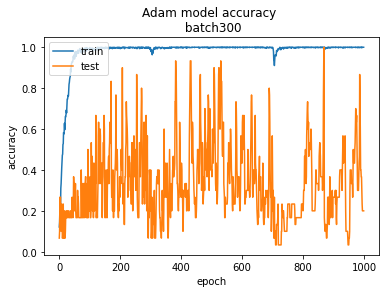

In [79]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Adam model accuracy \n batch300')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 아담 그레이드 , 비아너리 -> 바이너리 크로스 / 이건 분류하는 거-> multi class categoty  예측하는 확률을 보여준다. 
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=8000,batch_size = 300, validation_data = (X_test, y_test),callbacks=[tb_callback])


In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 20)            134640    
_________________________________________________________________
lstm_10 (LSTM)               (None, 20)                3280      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20)                80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_9 (Batch (None, 20)                80        
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)               

 -  모델의 결과 html 창으로 보기 
 - visualize the result of model



* cmd 창을 킨다 <br>

<br>
* C:\Users\User>cd Logs <br>
<br>
* C:\Users\User\Logs>cd Train<br>
<br>
* C:\Users\User\Logs\train>dir<br>

- 파일을 텐서플로우로 실행시킨다. (run the file )
* C:\Users\User\Logs\train>tensorboard --logdir=. 

- 링크를 복사하여 크롬창에 띄운다 ( copy the like and open it at Chrome)

# 예측하기 
8. Make Predictions

In [29]:
res = model.predict(X_test)

In [30]:
actions[np.argmax(res[3])]

'고치다'

In [31]:
actions[np.argmax(y_test[3])]

'고치다'

# 모델 저장 
9. Save Weights

In [32]:
#모델저장
model.save('trial_1000.h5')

In [ ]:
#모델 가중치 저장
#model.load_weights('trial1.h5')

# 모델 평가 
10. Evaluation using Confusion Matrix and Accuracy

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [34]:
yhat = model.predict(X_test)

In [35]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [36]:
multilabel_confusion_matrix(ytrue, yhat)
# 이원교차표 출력 

array([[[28,  0],
        [ 0,  2]],

       [[26,  0],
        [ 0,  4]],

       [[26,  0],
        [ 0,  4]],

       [[26,  0],
        [ 0,  4]],

       [[29,  0],
        [ 0,  1]],

       [[28,  0],
        [ 0,  2]],

       [[25,  0],
        [ 0,  5]],

       [[26,  0],
        [ 0,  4]],

       [[26,  0],
        [ 0,  4]]], dtype=int64)

In [37]:
accuracy_score(ytrue, yhat)

1.0

# 실시간 예측하기 
11. Test in Real Time

In [38]:
#모델 불러오기 
from tensorflow.keras.models import load_model

model = load_model('trial_1000.h5')

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

actions = np.array(['고치다','멈추다','춥다','고혈압', '저혈압','수술' ,'피곤하다','x-ray사진','충격','약'])

In [40]:
import cv2
import sys
import time
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import platform

def cv2_draw_label(image, text, point):
    x, y = point
    x, y = int(x), int(y)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    font = 'malgun.ttf' 
    draw = ImageDraw.Draw(pil_image)
    try:
        imageFont = ImageFont.truetype(font, 30) #글자크기 
    except:
        imageFont = ImageFont.load_default()
    draw.text((x, y), text, font=imageFont, fill=(255,255,255))  # 글자 색깔 
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image



# 내가 고찬거 
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        cnt = 0

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        print(keypoints)
        sequence.append(keypoints)
        
        print(len(sequence))
        sequence = sequence[-40:] #마지막 30프레임
        print(len(sequence))
        if len(sequence) == 40: #30개차면 predict한다 
            res = model.predict(np.expand_dims(sequence, axis=0))[0] # 2차원을 3차원으로 늘려준다. [0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
   

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
        print(sentence)    
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        image = cv2_draw_label(image, ' '.join(sentence), (0,10))
        #cv2.putText(image, ' '.join('hello'), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51033342  0.51920062 -0.50615221 ...  0.          0.
  0.        ]
1
1
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51563603  0.51576585 -0.64787573 ...  0.          0.
  0.        ]
2
2
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51828778  0.51437205 -0.61529505 ...  0.          0.
  0.        ]
3
3
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52012873  0.51348513 -0.68807769 ...  0.          0.
  0.        ]
4
4
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52113593  0.51272005 -0.70541549 ...  0.          0.
  0.        ]
5
5
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52231538  0.51201975 -0.70043385 ...  0.          0.
  0.        ]
6
6
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5233022   0.5114969  -0.70467973 ...  0.          0.
  0.        ]
7
7
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53467238  0.51204759 -0.87304431 ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53622591  0.51074374 -0.8436197  ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53942418  0.50989407 -0.83207428 ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54275763  0.50730091 -0.75343537 ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54527938  0.50682551 -0.69160998 ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5458492   0.50673717 -0.67264289 ...  0.          0.
  0.        ]
41
40
['멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54752445  0.5064652  -0.55820125 ...  0.23317291  0.8415271
 -0.0441583 ]
41
40
['멈추다']

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54880005  0.47431692 -0.62796861 ...  0.39962345  0.77366698
 -0.04621011]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54868639  0.47437143 -0.58006716 ...  0.37093168  0.78359967
 -0.04282108]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54802185  0.4751679  -0.72245711 ...  0.41566226  0.78234583
 -0.04819156]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54743826  0.47508082 -0.66907442 ...  0.40944326  0.78650129
 -0.05376742]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54663593  0.47555223 -0.6152854  ...  0.37654704  0.79854703
 -0.05067399]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54659951  0.47719428 -0.75052583 ...  0.39630008  0.80786085
 -0.04731335]
41
40
['멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56110913  0.28988221 -0.65137452 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56230795  0.2910541  -0.70778638 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56484514  0.29097182 -0.83483601 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56782514  0.29037443 -0.65902156 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56783909  0.289832   -0.54995942 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56857216  0.28899091 -0.53575087 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57415324  0.31056485 -0.64650428 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57360792  0.3116461  -0.64555103 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57358152  0.31199667 -0.69744718 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57352149  0.3131319  -0.76075447 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57329094  0.31399018 -0.74680442 ...  0.43072051  0.43819007
  0.02366216]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57338196  0.31419405 -0.86363763 ...  0.60736006  0.44762689


<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57774681  0.21879165 -0.75665247 ...  0.5896287   0.7856698
 -0.10312105]
41
40
['x-ray사진', '피곤하다', '춥다', '멈추다', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57818121  0.21822451 -0.67187035 ...  0.57360548  0.80946946
 -0.07295233]
41
40
['x-ray사진', '피곤하다', '춥다', '멈추다', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57838953  0.21785717 -0.69728696 ...  0.59497106  0.79526168
 -0.07297023]
41
40
['x-ray사진', '피곤하다', '춥다', '멈추다', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57942021  0.21781114 -0.67974985 ...  0.6417433   0.81810856
 -0.09008128]
41
40
['x-ray사진', '피곤하다', '춥다', '멈추다', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57967043  0.21784802 -0.73543465 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '멈추다', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58040386  0.21800846 -0.67631865 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5879398   0.4313224  -0.60130584 ...  0.31468728  0.71726125
 -0.03835691]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5861643   0.43130815 -0.57942623 ...  0.23405704  0.62966025
 -0.06186046]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58304775  0.4328039  -0.59478229 ...  0.20537885  0.60019028
 -0.1051711 ]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58251983  0.43405074 -0.58451992 ...  0.19551268  0.58103585
 -0.11709844]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58235562  0.43519109 -0.56100881 ...  0.20078108  0.5613206
 -0.12223359]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58221239  0.43711412 -0.53763473 ...  0.21096

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57275081  0.46210542 -0.49880752 ...  0.37412941  0.58417249
 -0.0251517 ]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57272136  0.4623971  -0.50101072 ...  0.37135139  0.58405328
 -0.02458097]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57270586  0.46259362 -0.5283106  ...  0.37381354  0.58563977
 -0.02544593]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5726034   0.46288642 -0.52922952 ...  0.37317795  0.5866847
 -0.02506502]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57243598  0.4629741  -0.52879244 ...  0.37301707  0.58685303
 -0.02651367]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57228976  0.46298519 -0.54131216 ...  0.37247

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53789574  0.46657017 -0.53859341 ...  0.23269932  0.61418134
 -0.08676379]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54015237  0.46668041 -0.53866935 ...  0.28990325  0.68067276
 -0.06505775]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54337472  0.46678305 -0.52456653 ...  0.3064453   0.67525852
 -0.0483864 ]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5457381   0.46681869 -0.52774155 ...  0.30918735  0.66274011
 -0.04112011]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5480383   0.46642417 -0.52742743 ...  0.31218889  0.65078318
 -0.04069713]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54980832  0.46593824 -0.52808064 ...  0.3131

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56291866  0.46709797 -0.56738317 ...  0.23595256  0.63668388
 -0.09400134]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56243134  0.46775708 -0.564592   ...  0.23818332  0.6289866
 -0.09446203]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56165242  0.46793836 -0.56085217 ...  0.24021888  0.62600905
 -0.09751812]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56118309  0.46828386 -0.54317057 ...  0.24579352  0.62719566
 -0.08440706]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56205022  0.46828482 -0.53734404 ...  0.31381002  0.66351402
 -0.06450135]
41
40
['피곤하다', '춥다', '멈추다', '피곤하다', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56242424  0.46898237 -0.51132435 ...  0.34323

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57720453  0.47399724 -0.69746959 ...  0.66965491  0.82610571
 -0.05860404]
41
40
['멈추다', '피곤하다', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57738948  0.47338077 -0.72125793 ...  0.66206264  0.83703756
 -0.05471321]
41
40
['멈추다', '피곤하다', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57768726  0.47328839 -0.76359677 ...  0.66489488  0.84451962
 -0.07079327]
41
40
['멈추다', '피곤하다', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57785732  0.47366098 -0.75284016 ...  0.66051388  0.84213519
 -0.08227067]
41
40
['멈추다', '피곤하다', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57778108  0.47371796 -0.74992615 ...  0.64390945  0.78946364
 -0.01740056]
41
40
['멈추다', '피곤하다', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57763058  0.47372153 -0.

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58799654  0.44573098 -1.01686656 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58831245  0.44847819 -0.95465291 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.58990049  0.44857293 -0.98420346 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.59091264  0.44948846 -0.94893819 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.59044045  0.45317915 -0.71198231 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5900982   0.45412025 -0.63247907 ...  0.         

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54999435  0.47719952 -0.46933085 ...  0.36184204  0.70674521
 -0.03526564]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53514427  0.47954395 -0.48337069 ...  0.3592006   0.71504027
 -0.03579339]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52010691  0.48006526 -0.47925368 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50433671  0.48012021 -0.47622299 ...  0.29453471  0.69910914
 -0.04321078]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49079388  0.48056144 -0.47672611 ...  0.3241269   0.71091712
 -0.04989673]
41
40
['멈추다', 'x-ray사진', '멈추다', 'x-ray사진', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48435321  0.48303

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46599397  0.20322832 -0.73629302 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46681285  0.20438571 -0.85272133 ...  0.36019883  0.48351279
 -0.00676644]
41
40
['x-ray사진', '멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46966511  0.20516415 -0.80774337 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47058415  0.20596026 -0.79906809 ...  0.32270011  0.46735823
 -0.02697322]
41
40
['x-ray사진', '멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47084838  0.20643072 -0.7057302  ...  0.34390247  0.46852231
 -0.0352652 ]
41
40
['x-ray사진', '멈추다', 'x-ray사진', '피곤하다', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47110128  0.20755076 -0.8

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.40192947  0.43092814 -0.68229032 ...  0.50915211  0.7477982
 -0.0494521 ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.40148592  0.43284419 -0.69911706 ...  0.50444186  0.75354379
 -0.05224321]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.40165108  0.433806   -0.74957728 ...  0.49999782  0.75350356
 -0.04679196]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.40447277  0.4346455  -0.73292369 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.40586171  0.43462563 -0.74019217 ...  0.50328362  0.7490679
 -0.04816575]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4058969   0.4349032  -0.74161106 ...  0

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.3935152   0.45270237 -0.71189868 ...  0.28610048  0.4734078
 -0.01537435]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.3917225   0.45285168 -0.71517557 ...  0.2923103   0.47510156
 -0.01375741]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.38978893  0.45283478 -0.70724279 ...  0.29355821  0.4738127
 -0.01100909]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.38878223  0.45281121 -0.68223751 ...  0.29841822  0.47240508
 -0.01071355]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.38781595  0.45279366 -0.69787335 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.38625416  0.4518905  -0.67014706 ...  0

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4562006   0.17793314 -0.52161735 ...  0.4312236   0.62014478
 -0.00652034]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46602264  0.16152215 -0.58616459 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46889886  0.15820035 -0.65608704 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47486559  0.15508136 -0.74015987 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47592521  0.15069224 -0.72840619 ...  0.          0.
  0.        ]
41
40
['멈추다', 'x-ray사진', '피곤하다', '춥다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48187414  0.15456079 -0.72689289 ...  0.          0.
  0.    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52456462  0.16451845 -0.60649407 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5245316   0.16493143 -0.52747381 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52455294  0.16452534 -0.52809525 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52378327  0.16478811 -0.81630689 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52364278  0.16383007 -0.71659577 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52358681  0.16255255 -0.60232353 ...  0.          0.
  0.        ]
41
40
['x-ra

[ 0.51500177  0.15511431 -0.62899429 ...  0.41134486  0.79301119
 -0.10502449]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51501888  0.16225412 -0.64221638 ...  0.4090293   0.78822494
 -0.10593416]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51788372  0.16995716 -0.68598974 ...  0.40885851  0.78042817
 -0.08726962]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52323991  0.1763458  -0.75522792 ...  0.41194642  0.7622025
 -0.08471568]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52964973  0.18351147 -0.81193286 ...  0.41644299  0.76584834
 -0.10607069]
41
40
['x-ray사진', '피곤하다', '춥다', '고치다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53131455  0.18828346 -0.76365656 ...  0.40465564  0.76548958
 -0.11708809]
41
40
['x-ray사진', '피곤하

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48131186  0.19007687 -0.62255788 ...  0.37771016  0.79474449
 -0.07545364]
41
40
['춥다', '고치다', '약', '춥다', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48038507  0.19000676 -0.69185984 ...  0.          0.
  0.        ]
41
40
['춥다', '고치다', '약', '춥다', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48014504  0.1905618  -0.70265853 ...  0.43677834  0.79230529
 -0.08152198]
41
40
['춥다', '고치다', '약', '춥다', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47968549  0.19103339 -0.66966689 ...  0.43442056  0.79428262
 -0.08380149]
41
40
['춥다', '고치다', '약', '춥다', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47959676  0.19145292 -0.6275807  ...  0.43055379  0.789644
 -0.083551  ]
41
40
['춥다', '고치다', '약', '춥다', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47961101  0.19033392 -0.61425585 ...  0.42901087  0.77175426
 -0.07574742]
41
40
['춥

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4926303   0.12668678 -0.53545564 ...  0.42727879  0.53544366
 -0.05240847]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4926587   0.12645762 -0.53740704 ...  0.43615356  0.54141277
 -0.04887774]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49266714  0.12639254 -0.53955156 ...  0.45306352  0.55050802
 -0.05222891]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49267453  0.12619679 -0.54341412 ...  0.46133924  0.56098014
 -0.0516611 ]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49276775  0.12555295 -0.57768494 ...  0.46680611  0.57040781
 -0.0512518 ]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49308425  0.12408519 -0.60143363 ...  0.47024256  0.5780015
 -0.05245001]
41
40

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49769187  0.0994978  -0.54094583 ...  0.41301274  0.58659732
 -0.05734894]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49759871  0.09970251 -0.54870164 ...  0.34521249  0.55080545
 -0.07141435]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49774987  0.09984443 -0.54110837 ...  0.19483803  0.40209708
 -0.05535056]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49773139  0.09940159 -0.54317468 ...  0.21585643  0.44986281
 -0.03532235]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49757499  0.0990738  -0.52982527 ...  0.22925723  0.41327497
 -0.05135843]
41
40
['고치다', '약', '춥다', '충격', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49758005  0.09881281 -0.53110862 ...  0.31720501  0.42947024
 -0.06367987]
41
4

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49671468  0.1025583  -0.52933466 ...  0.0927635   0.23977353
 -0.14385012]
41
40
['약', '춥다', '충격', '약', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49653253  0.10253333 -0.51145929 ...  0.10294272  0.2102983
 -0.10542295]
41
40
['약', '춥다', '충격', '약', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49654698  0.10295567 -0.50177366 ...  0.10879753  0.22742875
 -0.14572401]
41
40
['약', '춥다', '충격', '약', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49668455  0.1048691  -0.49670357 ...  0.14775273  0.23362222
 -0.12153731]
41
40
['약', '춥다', '충격', '약', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49847752  0.10765135 -0.50239938 ...  0.1833728   0.24861759
 -0.11426428]
41
40
['약', '춥다', '충격', '약', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49845752  0.10803784 -0.49217302 ...  0.19727007  0.25973949
 -0.09119536]
41
40
['약'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4992241   0.10368478 -0.54135263 ...  0.22900821  0.36623502
 -0.0838868 ]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49922165  0.10351727 -0.53850865 ...  0.20369141  0.36006826
 -0.06422078]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4995749   0.10308173 -0.54010904 ...  0.15727386  0.3291434
 -0.09074169]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50029892  0.10323565 -0.53701651 ...  0.14180607  0.32618791
 -0.12178934]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5013774   0.10342104 -0.5393846  ...  0.14223707  0.33268654
 -0.1265121 ]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50244558  0.10334793 -0.53901058 ...  0.14237861  0.33726266
 -0.13183787]
41
40
['약', '춥다

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50840533  0.10368776 -0.49501148 ...  0.27440247  0.39745817
 -0.04868764]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50872672  0.10428061 -0.4888359  ...  0.27545482  0.40102309
 -0.04699886]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50909954  0.10475361 -0.48392802 ...  0.26917732  0.40086293
 -0.05407735]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51009679  0.10753521 -0.51152223 ...  0.2669746   0.4064002
 -0.05076008]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5114519   0.10900068 -0.51094031 ...  0.2567901   0.41836411
 -0.06614966]
41
40
['약', '춥다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51028872  0.11074894 -0.50737321 ...  0.23625597  0.40271974
 -0.07348052]
41
40
['약', '춥다

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5232774   0.1656272  -0.4233312  ...  0.21764773  0.35156086
 -0.09056606]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52035391  0.16318728 -0.42430353 ...  0.21187456  0.40924013
 -0.11992677]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51889277  0.15975852 -0.43750364 ...  0.22158356  0.42248762
 -0.1239455 ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51814514  0.1579085  -0.45466691 ...  0.24318802  0.39420593
 -0.1052493 ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51739722  0.15652309 -0.45908493 ...  0.36496666  0.33161774
 -0.06508433]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51713562  0.15240748 -0.49057227 ...  0.23991936  0.40273222
 -0.09427056]
41
40
['약', '춥

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48259959  0.21332975 -0.4785009  ...  0.19273281  0.40171999
 -0.10560963]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48266119  0.21585546 -0.46869022 ...  0.1868203   0.43004754
 -0.10710162]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48282617  0.22047137 -0.46418208 ...  0.18290721  0.44839907
 -0.10549215]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48341316  0.22431636 -0.47144479 ...  0.18558966  0.45625776
 -0.10995781]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48530468  0.22532681 -0.48322684 ...  0.19101653  0.48258567
 -0.10565632]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4864431   0.22685292 -0.47943693 ...  0.22087258  0.50085592
 -0.08601364]
41
40
['약', '춥

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45897645  0.4573589  -0.63841856 ...  0.4742434   0.83619386
 -0.02131102]
41
40
['약', '수술', '약', '수술', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45770764  0.45752239 -0.6161105  ...  0.51327986  0.80644119
 -0.03946817]
41
40
['약', '수술', '약', '수술', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45644751  0.45727742 -0.58684427 ...  0.53427005  0.7788949
 -0.01654205]
41
40
['약', '수술', '약', '수술', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45548287  0.45711797 -0.5707798  ...  0.56619972  0.74864024
 -0.03846323]
41
40
['약', '수술', '약', '수술', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45350966  0.45692691 -0.57270193 ...  0.54258001  0.75834107
 -0.03019538]
41
40
['약', '수술', '약', '수술', '멈추다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45289859  0.45706752 -0.61827034 ...  0.54243612  0.7616654
 -0.03557391]
41
40


<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46193749  0.46254283 -0.59979928 ...  0.46631178  0.90111661
 -0.01598859]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46142077  0.46271536 -0.5833897  ...  0.45986772  0.88399661
 -0.01331342]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46098304  0.46259457 -0.58365178 ...  0.45831195  0.86670268
 -0.01494734]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45953378  0.46293536 -0.57660025 ...  0.45505977  0.83875972
 -0.01760485]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45899931  0.46362692 -0.59782231 ...  0.4591977   0.81186771
 -0.020376  ]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45803815  0.46468458 -0.61194599 ...  0.47374138 

[ 0.45533729  0.45852184 -0.47923175 ...  0.          0.
  0.        ]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45533571  0.45846018 -0.52372277 ...  0.          0.
  0.        ]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4552567   0.45839036 -0.52591956 ...  0.51603061  0.86115062
 -0.05534241]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4551464   0.45837861 -0.55069405 ...  0.5156585   0.8852815
 -0.03807609]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45469409  0.45854521 -0.58076298 ...  0.51121497  0.89917189
 -0.01869308]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45442694  0.45962155 -0.57798332 ...  0.5059225   0.91031587
 -0.01465563]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46205887  0.46140996 -0.52495271 ...  0.36777583  0.75451863
 -0.03585724]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45974296  0.46311834 -0.53783154 ...  0.31965363  0.74111456
 -0.06000187]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45763564  0.4643622  -0.49787411 ...  0.          0.
  0.        ]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45721039  0.46783379 -0.52350771 ...  0.32613745  0.74180472
 -0.05297113]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45688215  0.46982729 -0.52860153 ...  0.36839902  0.71497482
 -0.03259829]
41
40
['수술', '약', '수술', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.45625448  0.47090384 -0.52332324 ...  0.3748239   0.74971

['약', '수술', '멈추다', 'x-ray사진', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46706772  0.13392064 -0.67944717 ...  0.          0.
  0.        ]
41
40
['약', '수술', '멈추다', 'x-ray사진', '피곤하다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46790266  0.13439645 -0.56163895 ...  0.26255202  0.43759999
 -0.0580951 ]
41
40
['수술', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46797228  0.13690667 -0.57117379 ...  0.          0.
  0.        ]
41
40
['수술', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4679656   0.13840309 -0.60228056 ...  0.35150793  0.41310385
 -0.03464079]
41
40
['수술', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.46833014  0.13858642 -0.57304692 ...  0.          0.
  0.        ]
41
40
['수술', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47002476  0.139045   -0.5

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49787164  0.19836007 -0.55556154 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '피곤하다', '약', '춥다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49660206  0.19732398 -0.55708086 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '춥다', '약', '수술']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49392468  0.19660231 -0.55820256 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '춥다', '약', '수술']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48792529  0.19191697 -0.56477112 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '춥다', '약', '수술']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48529515  0.1905797  -0.57710528 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '춥다', '약', '수술']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48101965  0.18836853 -0.58342123 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '춥다', '약', '수술']
<clas

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.51545012  0.1670537  -0.61130512 ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5259164   0.16996659 -0.61465609 ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53496832  0.17416438 -0.61492169 ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5422132   0.18265603 -0.6249789  ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5442366   0.19579975 -0.68487626 ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54250371  0.21907325 -0.67719215 ...  0.          0.
  0.        ]
41
40
['약', '춥다', '약', '수술', '약']
<class 'mediapipe.python.sol

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49233428  0.4271192  -0.77171761 ...  0.31126067  0.62393093
 -0.03144841]
41
40
['수술', '약', '피곤하다', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49163556  0.42629972 -0.76954198 ...  0.31021878  0.6205467
 -0.02741606]
41
40
['수술', '약', '피곤하다', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49169168  0.42633    -0.80382812 ...  0.30641294  0.62047857
 -0.02099268]
41
40
['수술', '약', '피곤하다', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49209833  0.42643881 -0.60727972 ...  0.29959464  0.62043846
 -0.02536315]
41
40
['수술', '약', '피곤하다', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.491285    0.42662105 -0.69551879 ...  0.          0.
  0.        ]
41
40
['수술', '약', '피곤하다', '멈추다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49138898  0.42802656 -0.7623775  ...  0.        

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5008136   0.12493149 -0.60372776 ...  0.36832866  0.42169479
 -0.03733492]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50280732  0.12192644 -0.63379401 ...  0.33241984  0.39926496
 -0.00229346]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50382185  0.12040285 -0.58792388 ...  0.32698071  0.39610881
  0.00510369]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50422597  0.11912847 -0.53834885 ...  0.32436246  0.39890936
  0.02253282]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50449616  0.11867487 -0.54129016 ...  0.          0.
  0.        ]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50523806  0.11867917 -0.52507478 ... 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50585663  0.08403113 -0.58401459 ...  0.50762159  0.57969022
 -0.03618621]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5061087   0.08571368 -0.59863472 ...  0.54739314  0.49932563
 -0.03973303]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50635439  0.08704902 -0.60548925 ...  0.56140757  0.48589569
 -0.04500409]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50704628  0.08711804 -0.5998717  ...  0.57098037  0.48121476
 -0.0421688 ]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50718462  0.08708784 -0.61263382 ...  0.58208275  0.49875367
 -0.05107006]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50738442  0.08686481 -0.62135

[ 0.50178349  0.06557544 -0.56384081 ...  0.48646197  0.71791673
 -0.02531067]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50162995  0.06646927 -0.57049626 ...  0.48323587  0.72291577
 -0.02993315]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.50052106  0.0706854  -0.56947565 ...  0.47108829  0.74257189
 -0.03918434]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49981546  0.07273439 -0.56865197 ...  0.4621222   0.73276925
 -0.04152546]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49969703  0.07489935 -0.56837475 ...  0.45394251  0.69707823
 -0.05109149]
41
40
['피곤하다', '멈추다', 'x-ray사진', '피곤하다', '약']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49980956  0.07489626 -0.59209722 ...  0.47723907  0.60177112
 -0.04907267]
41
40
['피곤하

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48222628  0.47320032 -0.82254064 ...  0.26704994  0.46329519
 -0.04173386]
41
40
['x-ray사진', '피곤하다', '약', '피곤하다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48308325  0.4731935  -0.84615964 ...  0.26553747  0.46778888
 -0.04170137]
41
40
['x-ray사진', '피곤하다', '약', '피곤하다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48363608  0.47328025 -0.8546524  ...  0.26447102  0.46544465
 -0.03755617]
41
40
['x-ray사진', '피곤하다', '약', '피곤하다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48426619  0.47357464 -0.84546775 ...  0.26640779  0.46497384
 -0.02840155]
41
40
['x-ray사진', '피곤하다', '약', '피곤하다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48210722  0.47351894 -0.8340227  ...  0.25971043  0.4719162
 -0.02810162]
41
40
['x-ray사진', '피곤하다', '약', '피곤하다', '고치다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4793312   0.47320223 -0.566532

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4949351   0.47972918 -0.53767467 ...  0.278281    0.50800765
 -0.02888683]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49175268  0.4775975  -0.51326442 ...  0.28367212  0.53801429
 -0.0365528 ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48970023  0.472846   -0.51683402 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48391157  0.47026411 -0.74898708 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48288006  0.46938765 -0.65498096 ...  0.29236713  0.80639184
 -0.05286535]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48355669  0.46942016 -0.715424   ...  0.32589

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47612721  0.48047554 -0.49772152 ...  0.30927649  0.50134379
 -0.02962522]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47612819  0.48053056 -0.49959365 ...  0.30859125  0.49751085
 -0.02828027]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47625384  0.48065659 -0.50830752 ...  0.3089481   0.49532384
 -0.02680788]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47629586  0.48067889 -0.51585031 ...  0.30501547  0.49354151
 -0.02576939]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47630054  0.48072541 -0.51032281 ...  0.30567873  0.49412972
 -0.0236252 ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47652173  0.48083764 -0.50423

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47459897  0.47503087 -0.49756718 ...  0.342747    0.67161328
 -0.044843  ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47509494  0.47517106 -0.4843978  ...  0.37458131  0.67648709
 -0.0459282 ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47580633  0.47530407 -0.50161225 ...  0.39386564  0.68487078
 -0.03832439]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.47772941  0.47446969 -0.49762052 ...  0.          0.
  0.        ]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.48094082  0.47338882 -0.4717218  ...  0.32142928  0.65294623
 -0.05024075]
41
40
['피곤하다', '약', '피곤하다', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49219579  0.45750609 -0.47736835 ... 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.67160141  0.07730261 -0.65505224 ...  0.54073358  0.65533948
 -0.04804204]
41
40
['고치다', 'x-ray사진', '약', '춥다', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.70583409  0.06317625 -0.62614465 ...  0.          0.
  0.        ]
41
40
['고치다', 'x-ray사진', '약', '춥다', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.72719663  0.06463111 -0.55436909 ...  0.          0.
  0.        ]
41
40
['고치다', 'x-ray사진', '약', '춥다', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.71314317  0.05662023 -0.85322726 ...  0.          0.
  0.        ]
41
40
['고치다', 'x-ray사진', '약', '춥다', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.69982803  0.05397253 -0.78952271 ...  0.          0.
  0.        ]
41
40
['고치다', 'x-ray사진', '약', '춥다', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.68042511  0.04981346 -0.76494277 ...  0.          0.
  0.        ]
41
40
['고

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57525814  0.47157291 -0.75321031 ...  0.35967332  0.38162425
 -0.02314353]
41
40
['약', '춥다', '고혈압', '피곤하다', '저혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57066441  0.47043112 -0.79252279 ...  0.35637045  0.41581219
 -0.02392612]
41
40
['약', '춥다', '고혈압', '피곤하다', '저혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57058716  0.46692169 -0.78996545 ...  0.3487615   0.4684307
 -0.02220861]
41
40
['약', '춥다', '고혈압', '피곤하다', '저혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57083505  0.46648979 -0.7241236  ...  0.3477993   0.48901555
 -0.0251078 ]
41
40
['약', '춥다', '고혈압', '피곤하다', '저혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.572092    0.46609175 -0.72137094 ...  0.3251467   0.60717577
 -0.00853238]
41
40
['약', '춥다', '고혈압', '피곤하다', '저혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.57477486  0.46599448 -0.72639936 ...  0.33831313  0.67763549

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56105262  0.47431958 -0.5557152  ...  0.41054848  0.52617353
 -0.02225017]
41
40
['춥다', '고혈압', '피곤하다', '저혈압', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56051213  0.47669294 -0.52070314 ...  0.40854058  0.52048093
 -0.01704775]
41
40
['춥다', '고혈압', '피곤하다', '저혈압', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55601805  0.4771719  -0.50929219 ...  0.403218    0.51580083
 -0.01511702]
41
40
['춥다', '고혈압', '피곤하다', '저혈압', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54793561  0.47775498 -0.53290868 ...  0.40106553  0.51625091
 -0.00719777]
41
40
['춥다', '고혈압', '피곤하다', '저혈압', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54286689  0.478641   -0.53855723 ...  0.39514592  0.51534319
 -0.00352456]
41
40
['춥다', '고혈압', '피곤하다', '저혈압', '고혈압']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54126722  0.47896528 -0.48773003 ...  0.38535574 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56350213  0.47443327 -0.57531071 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56482905  0.47572786 -0.56841743 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56572425  0.47792146 -0.54443872 ...  0.4188017   0.47596884
 -0.01045913]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5685643   0.47913378 -0.4767015  ...  0.42000598  0.47681245
 -0.00672581]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5681752   0.47920811 -0.49754125 ...  0.4154833   0.48902106
 -0.00258187]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56800377  0.47923702 -0.50246108 ...  0.

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52838665  0.48322505 -0.5139538  ...  0.37963653  0.49561819
 -0.00904172]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5287956   0.48252696 -0.5314151  ...  0.36681429  0.4796721
 -0.00092607]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52894104  0.48237884 -0.58018094 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52872527  0.48134413 -0.58619887 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52915037  0.48090106 -0.57665718 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52907175  0.48375943 -0.57191253 ...  0.         

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52305424  0.46730322 -0.58185637 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52502131  0.46685952 -0.58132112 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52604735  0.46664578 -0.57541066 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52666289  0.46669489 -0.57854331 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53081912  0.46630561 -0.66804016 ...  0.          0.
  0.        ]
41
40
['피곤하다', '저혈압', '고혈압', '고치다', 'x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.53547078  0.46644926 -0.66778767 ...  0.          0.
  0.       

[ 0.54390514  0.50023937 -1.17054987 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.5441466   0.5003531  -1.18211496 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54421449  0.50037873 -1.18402934 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54434359  0.50038606 -1.20037818 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54445577  0.50048149 -1.18635654 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.54455674  0.500857   -1.17720771 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.p

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55395365  0.5424403  -1.18749642 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55417085  0.54036438 -1.19188643 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55430162  0.53752542 -1.18139732 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55453479  0.5348841  -1.18328583 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55455112  0.53332466 -1.16750944 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55468613  0.53318059 -1.11672223 ...  0.          0.
  0.        ]
41
40
[

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55362666  0.53786123 -1.21331489 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55367029  0.53737259 -1.21316671 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55369872  0.53615093 -1.21236062 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55371809  0.53514159 -1.21394277 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55381286  0.53380173 -1.21336865 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55408549  0.53295618 -1.20834279 ...  0.          0.
  0.        ]
41
40
[

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55455792  0.52033836 -1.15365183 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55445802  0.51987606 -1.15532184 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55422133  0.51973164 -1.14761662 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55392009  0.51893592 -1.14910388 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55342644  0.5185203  -1.15048671 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55271679  0.51797473 -1.1402179  ...  0.          0.
  0.        ]
41
40
[

[ 0.55921817  0.52054042 -1.10751212 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55947489  0.52054644 -1.12554264 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55964953  0.52055401 -1.11659348 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55976236  0.52066648 -1.11929512 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55979466  0.52118897 -1.1218791  ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.55981594  0.52130288 -1.10751295 ...  0.          0.
  0.        ]
41
40
['저혈압', '고혈압', '고치다', 'x-ray사진', '춥다']
<class 'mediapipe.p

In [43]:
## open cv창 끄기 

cap.release()
cv2.destroyAllWindows()